In [1]:
import uproot as ut
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from uproot3_methods import TLorentzVectorArray
import vector
import awkward as ak
from tqdm import tqdm
%matplotlib inline

import numpy as np

from cutConfig import *

In [2]:
class Branches:
    def __init__(self,ttree):
        self.ttree = ttree
    def __getitem__(self,key): return self.ttree[key].array()

filename = "../signal/NanoAOD/NMSSM_XYH_YToHH_6b_MX_700_MY_400_accstudies_500k_May2021.root:sixBtree"
ttree = ut.open(filename)
branches_all = Branches(ttree)
nevents_all = ak.size( branches_all["Run"] )

In [3]:
total_events = 100000
branches = branches_all
nevents = ak.size( branches["Run"] )

sixb_found_mask = branches["nfound_all"] == 6
nsignal = ak.sum(sixb_found_mask)
sixb_jets = branches["signal_bjet_index"]

In [4]:
# --- Standard Preselection --- #
def std_preselection(branches,ptcut=30,etacut=2.4,btagcut=None,jetid=1,puid=1):
    jet_pt_mask = branches["jet_ptRegressed"] > ptcut
    jet_eta_mask = np.abs(branches["jet_eta"]) < etacut
    jet_mask = jet_pt_mask & jet_eta_mask
    
    if btagcut: jet_mask = jet_mask & (branches["jet_btag"] > btagcut)
    if jetid: jet_mask = jet_mask & ((1 << jetid) == branches["jet_id"] & ( 1 << jetid ))
    if puid: 
        puid_mask = (1 << puid) == branches["jet_puid"] & ( 1 << puid )
        low_pt_pu_mask = (branches["jet_ptRegressed"] < 50) & puid_mask
        jet_pu_mask = (branches["jet_ptRegressed"] >= 50) | low_pt_pu_mask
        jet_mask = jet_mask & jet_pu_mask
    
    event_mask = ak.sum(jet_mask,axis=-1) >= 6
    return event_mask,jet_mask

In [5]:
def select_jets_simple(branches,varbranch,mask=None,jets=None,njets=6):
    if mask is None: mask = np.ones(ak.size(branches['Run']),dtype=bool)
    if jets is None: jets = branches["jet_pt"] > -999
    sorted_array = np.argsort(-varbranch[mask])
    selected_sorted_array = jets[mask][sorted_array]
    firstN_array = np.argsort(sorted_array[selected_sorted_array]) < njets
    selected_array = sorted_array[selected_sorted_array][firstN_array]
    return selected_array
def select_jets(branches,variable="jet_ptRegressed",mask=None,jets=None,njets=6):
    varbranch = branches[variable]
    return select_jets_simple(branches,varbranch,mask,jets,njets)

In [6]:
def count_sixb(test_selected,sixb_jets=sixb_jets,mask=None):
    nevts = ak.size(test_selected,axis=0)
    if mask is None: mask = np.ones(nevts,dtype=bool)
    sixb_jets = sixb_jets[mask]
    compare , _ = ak.broadcast_arrays( sixb_jets[:,None], test_selected)
    inter = (test_selected == compare)
    count = ak.sum(ak.flatten(inter,axis=-1),axis=-1)
    return count

In [7]:
def get_selected(branches,variable,mask=None,jets=None,sixb_jets=sixb_jets,sixb_found_mask=sixb_found_mask):
    if mask is None: mask = np.ones(ak.size(branches['Run']),dtype=bool)
    selected = select_jets(branches,variable,mask=mask,jets=jets)
    sixb_count = count_sixb(selected,sixb_jets,mask=mask)
    
    signal_selected = select_jets(branches,variable,mask=mask & sixb_found_mask,jets=jets)
    signal_sixb_count = count_sixb(signal_selected,sixb_jets,mask=mask & sixb_found_mask)
    
    return (selected,sixb_count),(signal_selected,signal_sixb_count)

In [8]:
def plot_simple(variable,branches=branches,mask=None,selected=None,bins=None,xlabel=None,title=None,label=None,figax=None):
    if figax is None: figax = plt.subplots()
    if mask is None: mask = np.ones(ak.size(branches['Run']),dtype=bool)
    (fig,ax) = figax
    
    data = branches[variable][mask]
    if selected is not None: data = branches[variable][mask][selected]
    data = ak.flatten( data,axis=-1 )
    
    ax.hist(data,bins=bins,label=label)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.legend()
def plot_mask_comparison(variable,branches=branches,mask=None,selected=None,signal_selected=None,sixb_jets=None
                              ,bins=None,xlabel=None,title=None,label="All Events",figax=None):
    if figax is None: figax = plt.subplots()
    if mask is None: mask = np.ones(ak.size(branches['Run']),dtype=bool)
    (fig,ax) = figax
    
    data1 = branches[variable][mask]
    if selected is not None and "jet_" in variable: data1 = branches[variable][mask][selected]
    data1 = ak.flatten( data1,axis=-1 ); nevts1 = len(data1)
    
    data2 = branches[variable][mask & sixb_found_mask]
    if signal_selected is not None and "jet_" in variable: data2 = branches[variable][mask & sixb_found_mask][signal_selected]
    data2 = ak.flatten( data2,axis=-1 ); nevts2 = len(data2)
    
    data3 = branches[variable][mask & sixb_found_mask]
    if sixb_jets is not None and "jet_" in variable: data3 = branches[variable][mask & sixb_found_mask][sixb_jets[mask & sixb_found_mask]]
    data3 = ak.flatten( data3,axis=-1 ); nevts3 = len(data3)
    
    ax.hist(data1,bins=bins,label=f"{label} ({nevts1:.2e})")
    ax.hist(data2,bins=bins,label=f"Gen Matched Six BJets ({nevts2:.2e})")
    
    if sixb_jets is not None and "jet_" in variable:
        ax.hist(data3,bins=bins,label=f"Signal Six BJets ({nevts3:.2e})",histtype="step",color="black",linewidth=2)
        
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.legend()
    
def plot_mask_simple_comparison(selected,signal_selected,bins=None,label="All Events",title=None,xlabel=None,figax=None):
    if figax is None: figax = plt.subplots()
    (fig,ax) = figax
        
    nevts1 = ak.size(selected)
    nevts2 = ak.size(signal_selected)
        
    ax.hist(selected,bins=bins,label=f"{label} ({nevts1:.2e})")
    ax.hist(signal_selected,bins=bins,label=f"Gen Matched Six BJets ({nevts2:.2e})")
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.legend()
    
def presel_study(branches=branches,mask=np.ones(nevents,dtype=bool),jet_mask=None,njets=6,
                 selected=None,signal_selected=None,sixb_jets=sixb_jets,sixb_count=None,signal_sixb_count=None,
                 title=None,saveas=None):
    print(f"--- {title} ---")
    varinfo = {
        f"jet_m":{"bins":np.linspace(0,60,100),"xlabel":"Jet Mass"},
        f"jet_ptRegressed":{"bins":np.linspace(0,200,100),"xlabel":"Jet Pt (GeV)"},
        f"jet_E":{"bins":np.linspace(0,300,100),"xlabel":"Jet Energy"},
        f"jet_btag":{"bins":np.linspace(0,1,100),"xlabel":"Jet Btag"},
        f"jet_eta":{"bins":np.linspace(-3,3,100),"xlabel":"Jet Eta"},
        f"jet_phi":{"bins":np.linspace(-3.14,3.14,100),"xlabel":"Jet Phi"},
    }
    mask_evnts = ak.sum(mask)
    signal_evnts= ak.sum(mask & sixb_found_mask)
    
    total_eff = mask_evnts/float(nevents)
    signal_eff = signal_evnts/float(nsignal)
    purity = signal_evnts/float(mask_evnts)
    
    nsixb = min(6,njets)
    total_score = sum( n*ak.sum(sixb_count == n)/float(nsixb) for n in range(nsixb+1))/float(mask_evnts)
    signal_score= sum( n*ak.sum(signal_sixb_count == n)/float(nsixb) for n in range(nsixb+1))/float(signal_evnts)
    
    prompt = [
        f"Event Efficiency:       {total_eff:0.2f}",
        f"Signal Efficiency:      {signal_eff:0.2f}",
        f"Signal Purity:          {purity:0.2f}",
        f"Event Selection Score:  {total_score:0.2f}",
        f"Signal Selection Score: {signal_score:0.2f}"
    ]
    
    print("\n".join(prompt))
    
    total_njet = branches["njet"][mask]
    if jet_mask is not None: total_njet = ak.sum(jet_mask[mask],axis=-1)
    
    signal_njet = branches["njet"][mask & sixb_found_mask]
    if jet_mask is not None: signal_njet = ak.sum(jet_mask[mask & sixb_found_mask],axis=-1)
    
    fig = plt.figure( figsize=(18,10) )
    nrows,ncols = 2,4
    gs = fig.add_gridspec(nrows=nrows,ncols=ncols)
    
    ax1 = fig.add_subplot( gs[0,0])
    ax2 = fig.add_subplot( gs[0,1])
    
    plot_mask_simple_comparison(total_njet,signal_njet,figax=(fig,ax1),bins=np.linspace(-0.5,21.5,23),xlabel="Number of Jets in Selection")
    plot_mask_simple_comparison(sixb_count,signal_sixb_count,figax=(fig,ax2),bins=np.linspace(-0.5,nsixb+1,nsixb+1),xlabel="N Signal Six B in Selection")
    
    for i,(var,info) in enumerate(varinfo.items()):
        ax = fig.add_subplot( gs[int( (i+2)/ncols),(i+2)%ncols] )
        plot_mask_comparison(var,branches=branches,mask=mask,selected=selected,signal_selected=signal_selected,
                             sixb_jets=sixb_jets,figax=(fig,ax),**info)
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()
    if saveas: fig.savefig(f"plots/{saveas}")
    

In [9]:
(pt_selected,sixb_count_pt),(signal_pt_selected,signal_sixb_count_pt) = get_selected(branches,"jet_ptRegressed")

In [10]:
(btag_selected,sixb_count_btag),(signal_btag_selected,signal_sixb_count_btag) = get_selected(branches,"jet_btag")

--- 6 Highest Pt Jets ---
Event Efficiency:       1.00
Signal Efficiency:      1.00
Signal Purity:          0.36
Event Selection Score:  0.73
Signal Selection Score: 0.81


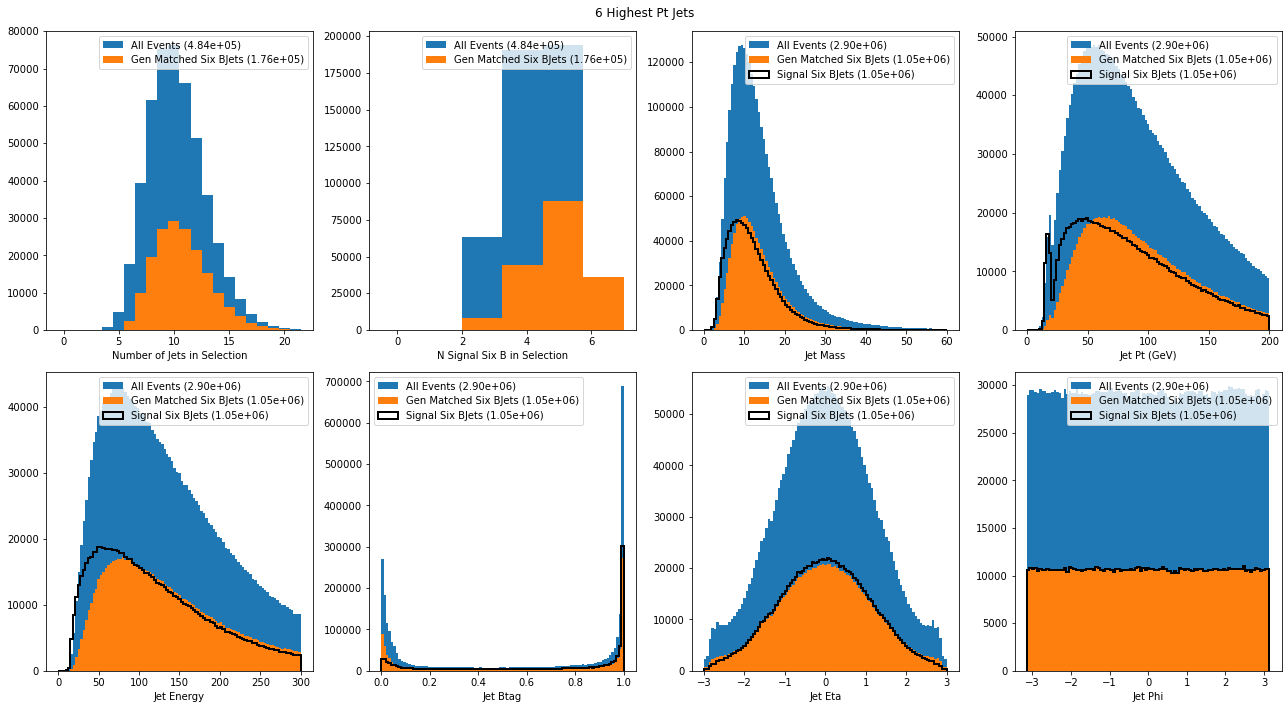

In [11]:
info = {
    "title":"6 Highest Pt Jets",
    "selected":pt_selected,
    "signal_selected":signal_pt_selected,
    "sixb_count":sixb_count_pt,
    "signal_sixb_count":signal_sixb_count_pt,
    "saveas":"baseline_high_pt.png"
}
presel_study(**info)

--- 6 Highest Btag Jets ---
Event Efficiency:       1.00
Signal Efficiency:      1.00
Signal Purity:          0.36
Event Selection Score:  0.64
Signal Selection Score: 0.72


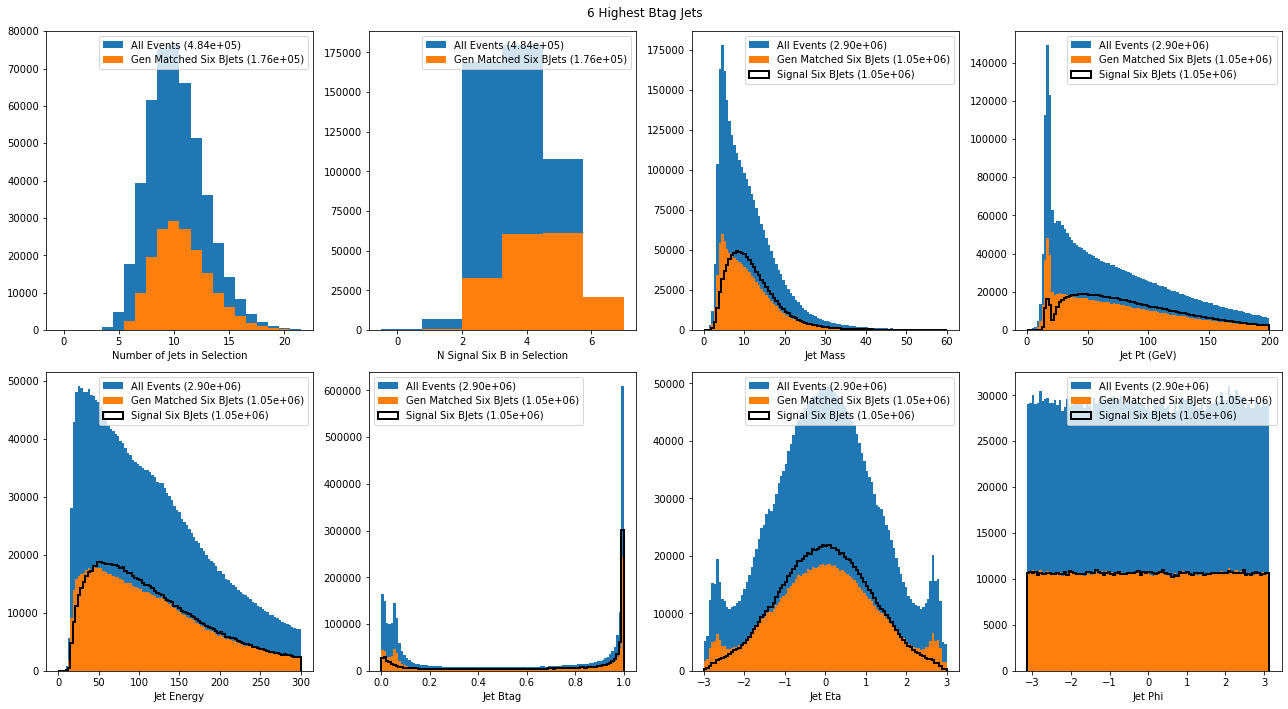

In [12]:
info = {
    "title":"6 Highest Btag Jets",
    "selected":btag_selected,
    "signal_selected":signal_btag_selected,
    "sixb_count":sixb_count_btag,
    "signal_sixb_count":signal_sixb_count_btag,
    "saveas":"baseline_high_btag.png"
}
presel_study(**info)

In [13]:
event_presel_mask, jet_presel_mask = std_preselection(branches)

(pt_preselected,pt_sixb_count_presel),(signal_pt_preselected,signal_pt_sixb_count_presel) = get_selected(branches,"jet_ptRegressed",mask=event_presel_mask,
                                                                                                         jets=jet_presel_mask)

(btag_preselected,btag_sixb_count_presel),(signal_btag_preselected,signal_btag_sixb_count_presel) = get_selected(branches,"jet_btag",mask=event_presel_mask,
                                                                                                                 jets=jet_presel_mask)

ptbtag = branches["jet_ptRegressed"] * branches["jet_btag"]

ptbtag_preselected = select_jets_simple(branches,ptbtag,mask=event_presel_mask,jets=jet_presel_mask)
ptbtag_sixb_count_presel = count_sixb(ptbtag_preselected,mask=event_presel_mask)

signal_ptbtag_preselected = select_jets_simple(branches,ptbtag,mask=event_presel_mask & sixb_found_mask,jets=jet_presel_mask)
signal_ptbtag_sixb_count_presel = count_sixb(signal_ptbtag_preselected,mask=event_presel_mask & sixb_found_mask)

--- STD Preselection 6 Highest Pt ---
Event Efficiency:       0.60
Signal Efficiency:      0.74
Signal Purity:          0.45
Event Selection Score:  0.75
Signal Selection Score: 0.82


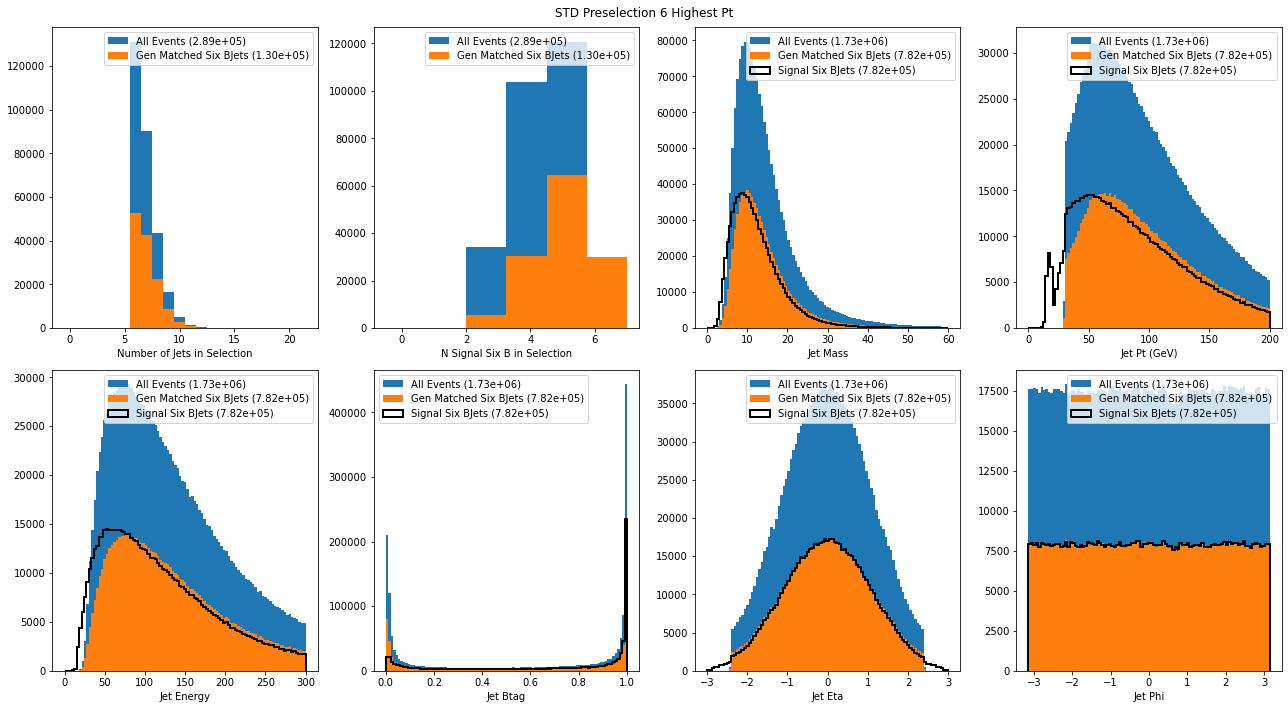

In [14]:
info = {
    "mask":event_presel_mask,
    "jet_mask":jet_presel_mask,
    "title":"STD Preselection 6 Highest Pt",
    "selected":pt_preselected,
    "signal_selected":signal_pt_preselected,
    "sixb_count":pt_sixb_count_presel,
    "signal_sixb_count":signal_pt_sixb_count_presel,
    "saveas":"presel_std_high_pt.png"
}
presel_study(**info)

--- STD Preselection 6 Highest Btag ---
Event Efficiency:       0.60
Signal Efficiency:      0.74
Signal Purity:          0.45
Event Selection Score:  0.74
Signal Selection Score: 0.81


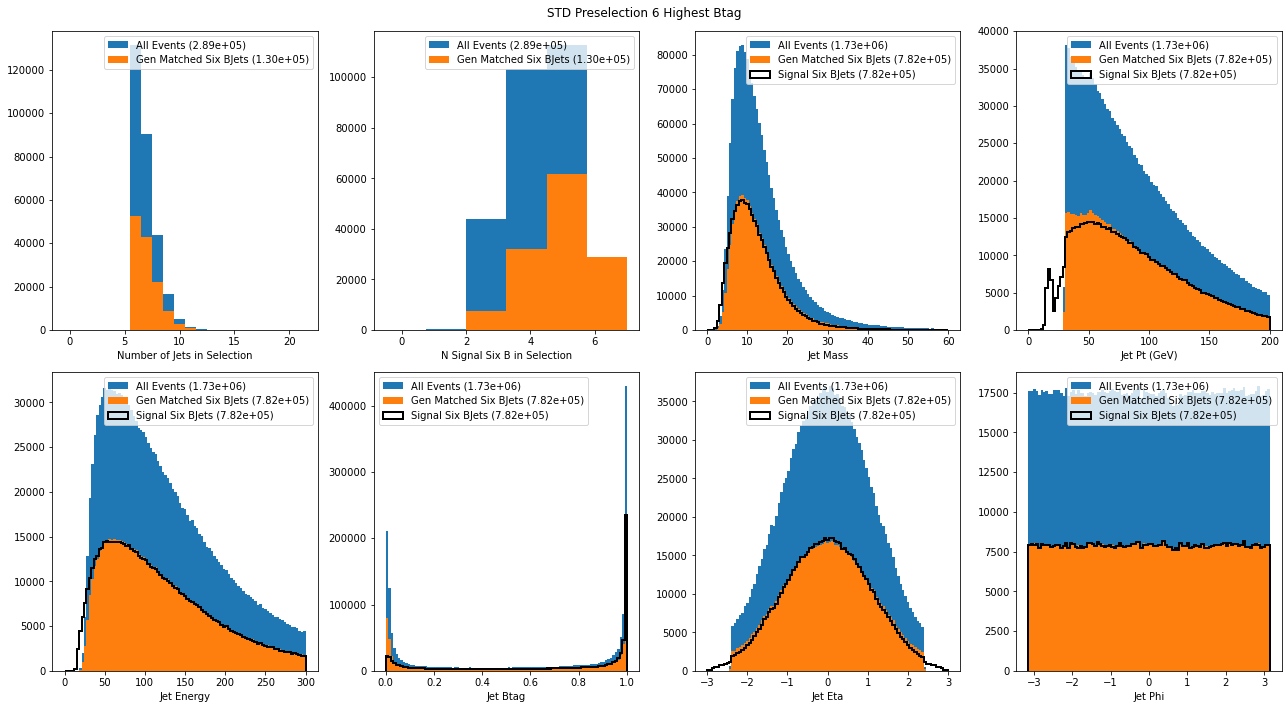

In [15]:
info = {
    "mask":event_presel_mask,
    "jet_mask":jet_presel_mask,
    "title":"STD Preselection 6 Highest Btag",
    "selected":btag_preselected,
    "signal_selected":signal_btag_preselected,
    "sixb_count":btag_sixb_count_presel,
    "signal_sixb_count":signal_btag_sixb_count_presel,
    "saveas":"presel_std_high_btag.png"
}
presel_study(**info)

--- Std Preselection 6 Highest PtBtag Jets ---
Event Efficiency:       0.60
Signal Efficiency:      0.74
Signal Purity:          0.45
Event Selection Score:  0.75
Signal Selection Score: 0.82


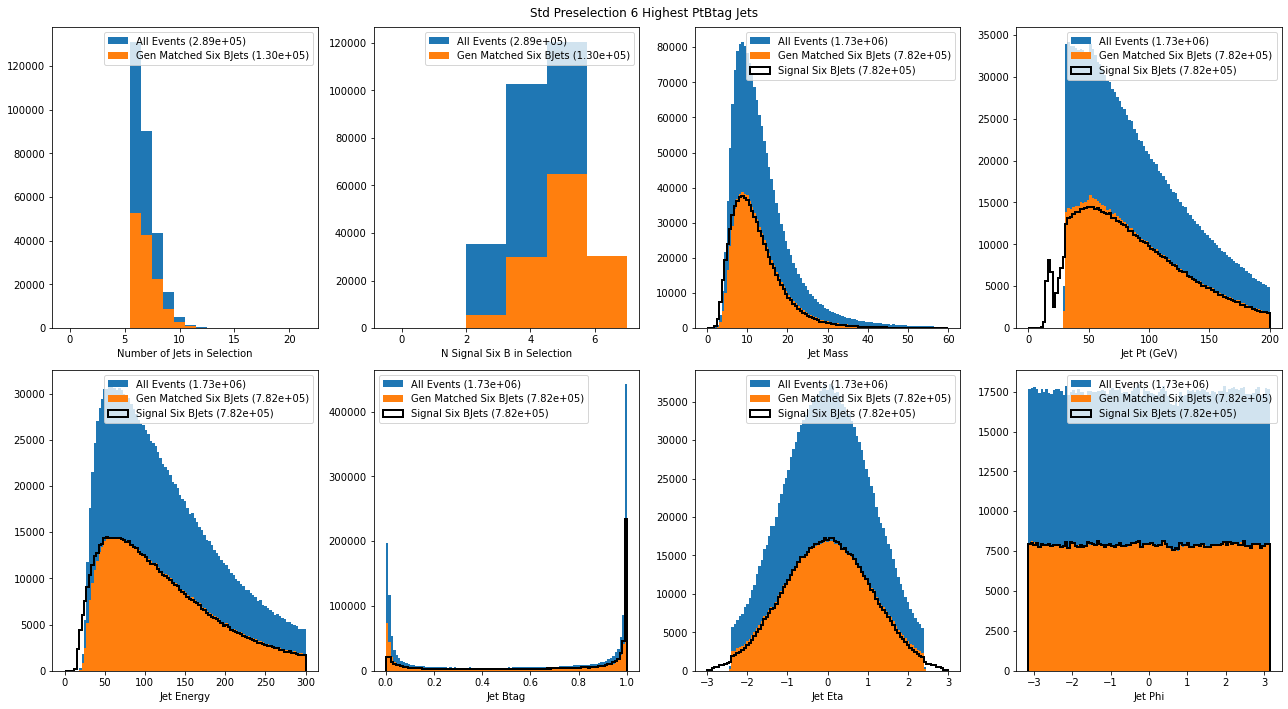

In [16]:
info = {
    "mask":event_presel_mask,
    "jet_mask":jet_presel_mask,
    "title":"Std Preselection 6 Highest PtBtag Jets",
    "selected":ptbtag_preselected,
    "signal_selected":signal_ptbtag_preselected,
    "sixb_count":ptbtag_sixb_count_presel,
    "signal_sixb_count":signal_ptbtag_sixb_count_presel,
    "saveas":"presel_std_high_ptbtag.png"
}
presel_study(**info)

In [17]:
event_presel_v2_mask, jet_presel_v2_mask = std_preselection(branches,btagcut=jet_btagWP[looseWP])
(pt_v2_preselected,sixb_count_v2_presel_pt),(signal_pt_v2_preselected,signal_sixb_count_v2_presel_pt) = get_selected(branches,"jet_ptRegressed",mask=event_presel_v2_mask,
                                                                                                                     jets=jet_presel_v2_mask)

(btag_v2_preselected,sixb_count_v2_presel_btag),(signal_btag_v2_preselected,signal_sixb_count_v2_presel_btag) = get_selected(branches,"jet_btag",mask=event_presel_v2_mask,
                                                                                                                             jets=jet_presel_v2_mask)

--- STD Preselection v2 Highest Pt ---
Event Efficiency:       0.18
Signal Efficiency:      0.33
Signal Purity:          0.66
Event Selection Score:  0.87
Signal Selection Score: 0.93


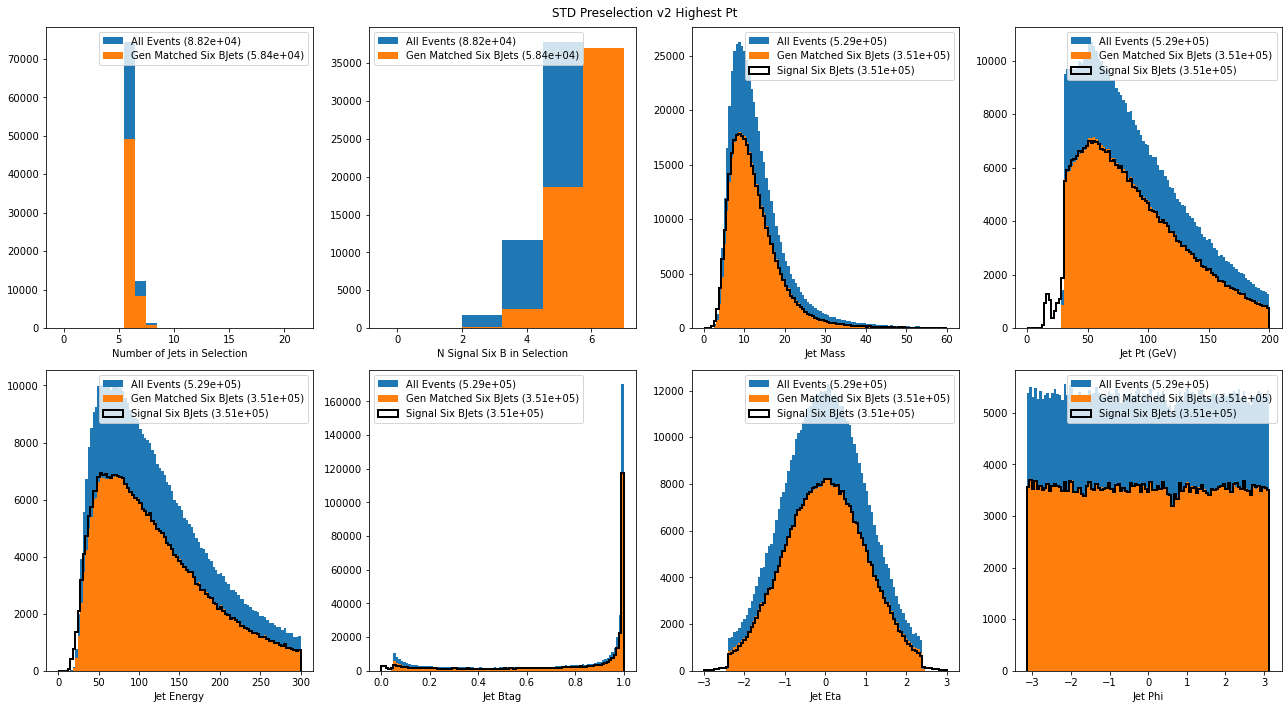

In [18]:
info = {
    "mask":event_presel_v2_mask,
    "title":"STD Preselection v2 Highest Pt",
    "selected":pt_v2_preselected,
    "signal_selected":signal_pt_v2_preselected,
    "sixb_count":sixb_count_v2_presel_pt,
    "signal_sixb_count":signal_sixb_count_v2_presel_pt,
    "jet_mask":jet_presel_v2_mask,
    "saveas":"presel_v2_high_pt.png"
}
presel_study(**info)

--- STD Preselection v2 Highest Btag ---
Event Efficiency:       0.18
Signal Efficiency:      0.33
Signal Purity:          0.66
Event Selection Score:  0.87
Signal Selection Score: 0.93


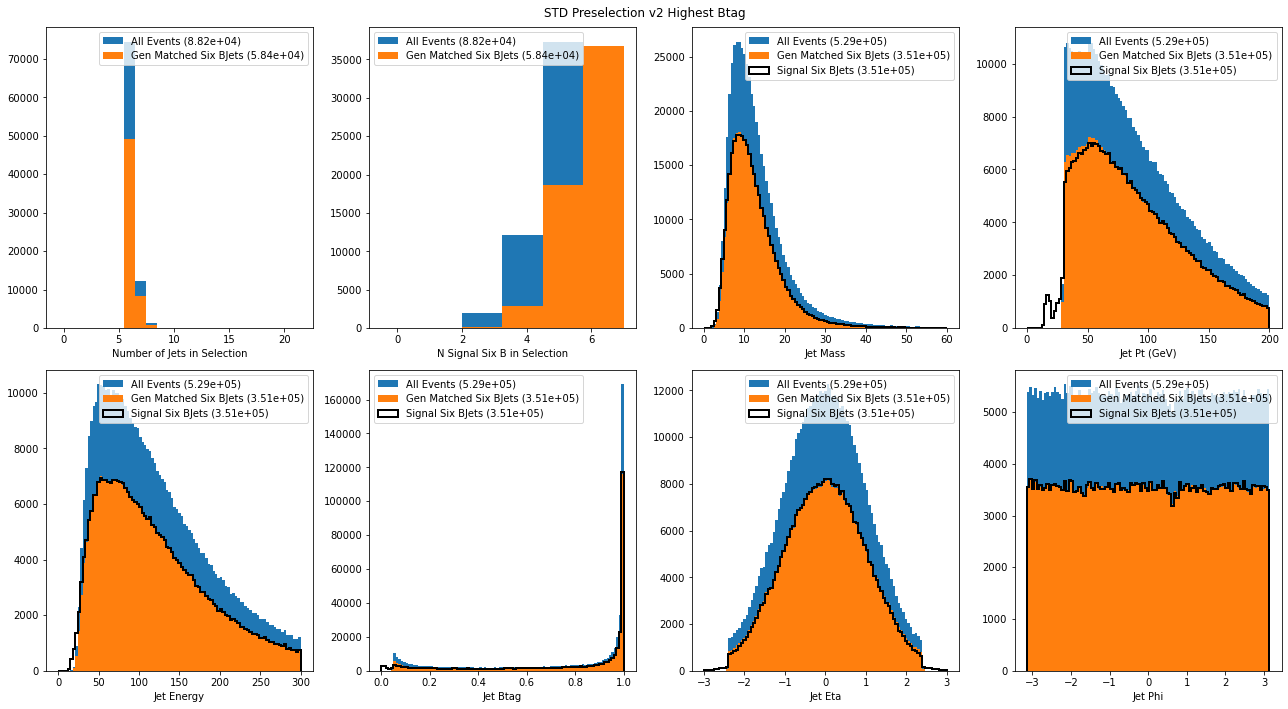

In [19]:
info = {
    "mask":event_presel_v2_mask,
    "title":"STD Preselection v2 Highest Btag",
    "selected":btag_v2_preselected,
    "signal_selected":signal_btag_v2_preselected,
    "sixb_count":sixb_count_v2_presel_btag,
    "signal_sixb_count":signal_sixb_count_v2_presel_btag,
    "jet_mask":jet_presel_v2_mask,
    "saveas":"presel_v2_high_btag.png"
}
presel_study(**info)

In [20]:
event_presel_v3_mask, jet_presel_v3_mask = std_preselection(branches,btagcut=jet_btagWP[mediumWP])
(pt_v3_preselected,sixb_count_v3_presel_pt),(signal_pt_v3_preselected,signal_sixb_count_v3_presel_pt) = get_selected(branches,"jet_ptRegressed",mask=event_presel_v3_mask,
                                                                                                                     jets=jet_presel_v3_mask)

(btag_v3_preselected,sixb_count_v3_presel_btag),(signal_btag_v3_preselected,signal_sixb_count_v3_presel_btag) = get_selected(branches,"jet_btag",mask=event_presel_v3_mask,
                                                                                                                             jets=jet_presel_v3_mask)

--- STD Preselection v3 Highest Pt ---
Event Efficiency:       0.07
Signal Efficiency:      0.14
Signal Purity:          0.77
Event Selection Score:  0.92
Signal Selection Score: 0.96


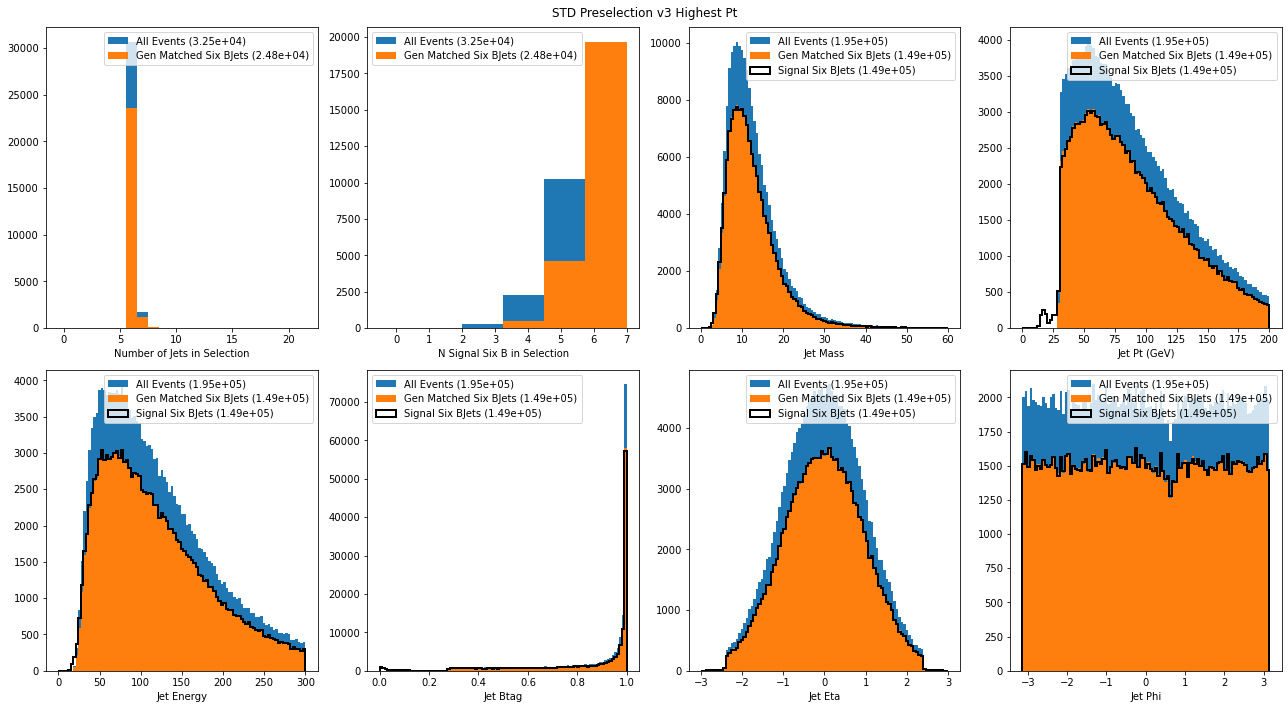

In [21]:
info = {
    "mask":event_presel_v3_mask,
    "title":"STD Preselection v3 Highest Pt",
    "selected":pt_v3_preselected,
    "signal_selected":signal_pt_v3_preselected,
    "sixb_count":sixb_count_v3_presel_pt,
    "signal_sixb_count":signal_sixb_count_v3_presel_pt,
    "jet_mask":jet_presel_v3_mask,
    "saveas":"presel_v3_high_pt.png"
}
presel_study(**info)

--- STD Preselection v3 Highest Btag ---
Event Efficiency:       0.07
Signal Efficiency:      0.14
Signal Purity:          0.77
Event Selection Score:  0.92
Signal Selection Score: 0.96


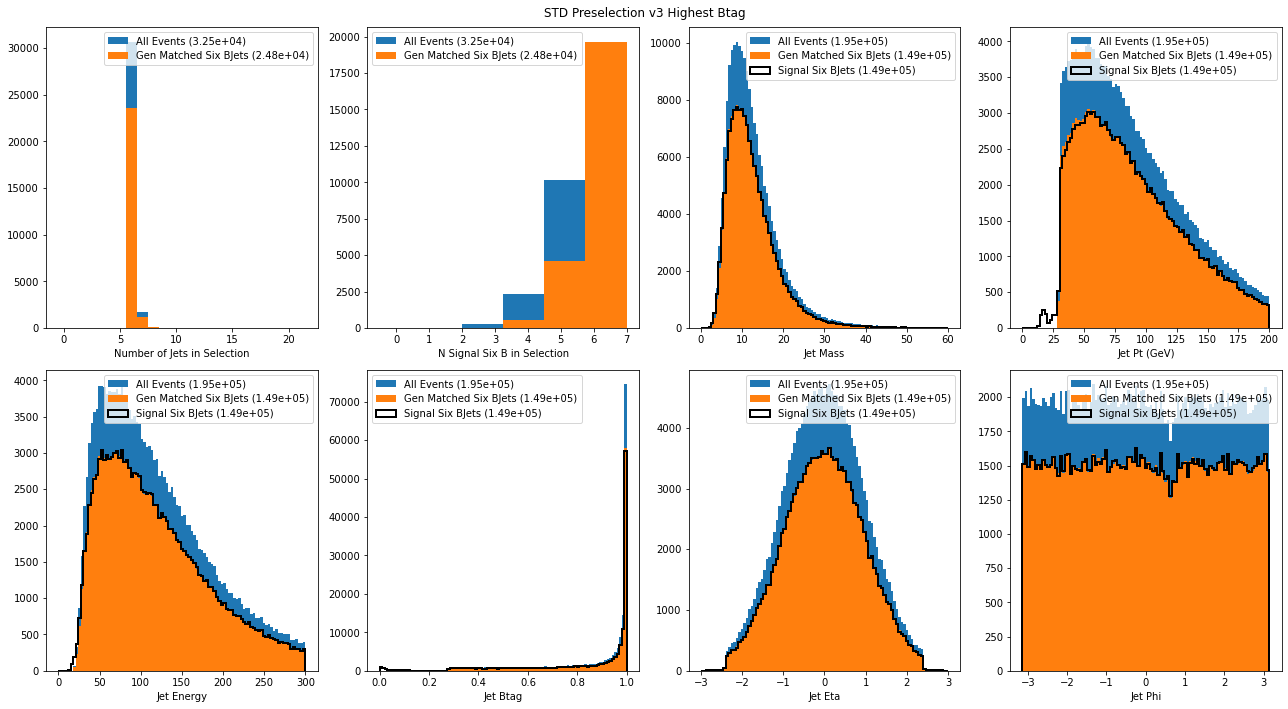

In [22]:
info = {
    "mask":event_presel_v3_mask,
    "title":"STD Preselection v3 Highest Btag",
    "selected":btag_v3_preselected,
    "signal_selected":signal_btag_v3_preselected,
    "sixb_count":sixb_count_v3_presel_btag,
    "signal_sixb_count":signal_sixb_count_v3_presel_btag,
    "jet_mask":jet_presel_v3_mask,
    "saveas":"presel_v3_high_btag.png"
}
presel_study(**info)